In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# --- Load Pretrained Model ---
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze for initial training

In [5]:
# --- Add Custom Layers ---
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 classes: Dog 1, Dog 2
])

In [6]:
# --- Compile Model ---
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
# --- Data Preparation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_dir = os.path.abspath('./data/train/')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [8]:
# --- Train Model (Frozen base) ---
model.fit(train_generator, validation_data=val_generator, epochs=10)

C:\Users\yenla\AppsByYen\GepperPinger\training\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8511 - loss: 0.4030 - val_accuracy: 1.0000 - val_loss: 0.0595
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9958 - loss: 0.0602 - val_accuracy: 1.0000 - val_loss: 0.0164
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 919ms/step - accuracy: 1.0000 - loss: 0.0213 - val_accuracy: 1.0000 - val_loss: 0.0129
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 853ms/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0086
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 0.9500 - val_loss: 0.0525
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 985ms/step - accuracy: 0.9979 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 962ms/step - accuracy: 0.9923 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 869ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 9.1665e

In [9]:
# --- Fine-tune Base Model ---
base_model.trainable = True
for layer in base_model.layers[:100]:  # keep early layers frozen
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
# Fine-tuning step
model.fit(train_generator, validation_data=val_generator, epochs=5)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9191 - loss: 0.2038 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8970 - loss: 0.2174 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 976ms/step - accuracy: 0.9577 - loss: 0.1101 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 946ms/step - accuracy: 0.9238 - loss: 0.1474 - val_accuracy: 0.9750 - val_loss: 0.0227
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 937ms/step - accuracy: 0.9796 - loss: 0.0874 - val_accuracy: 1.0000 - val_loss: 0.0029


In [11]:
# --- Test Data ---
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    os.path.abspath('./data/test/'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False  # Important for matching predictions
)

Found 20 images belonging to 2 classes.


In [12]:
# --- Evaluate Model ---
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 1.0000 - loss: 0.0283
Test Loss: 0.0283
Test Accuracy: 1.0000


In [13]:
# --- Save Model ---
model.save(os.path.join(os.path.abspath('./trained_models/'), 'dog_identifier_new.h5'))

In [14]:
# --- Analyze Predictions ---
class_names = list(test_generator.class_indices.keys())
y_pred_probs = model.predict(test_generator, verbose=1)
y_true = test_generator.classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)

correct_predictions = np.where(y_pred_classes == y_true)[0]
incorrect_predictions = np.where(y_pred_classes != y_true)[0]

print(f"Number of images correctly predicted: {len(correct_predictions)}")
print(f"Number of images incorrectly predicted: {len(incorrect_predictions)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Number of images correctly predicted: 20
Number of images incorrectly predicted: 0


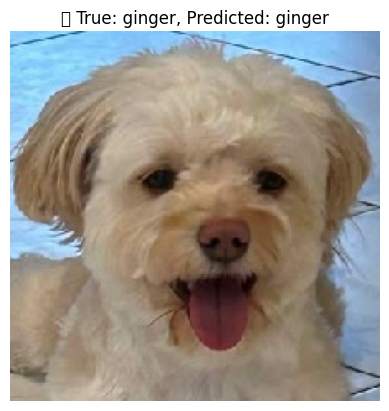

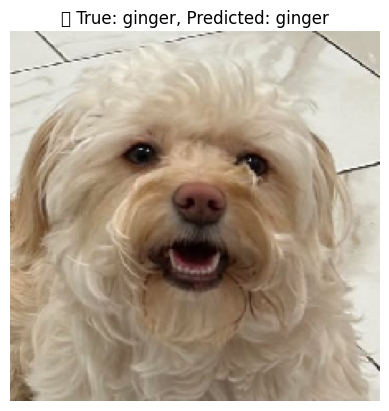

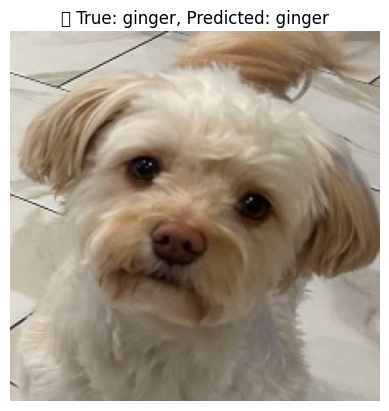

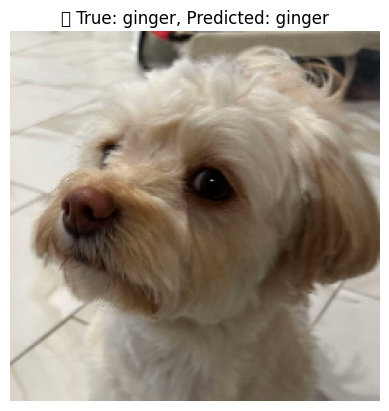

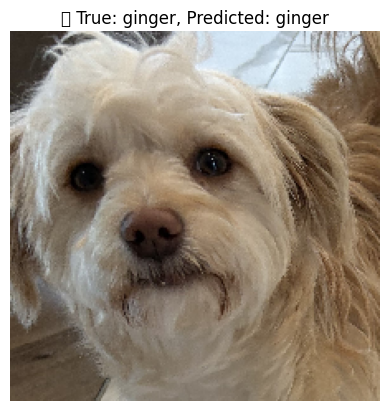

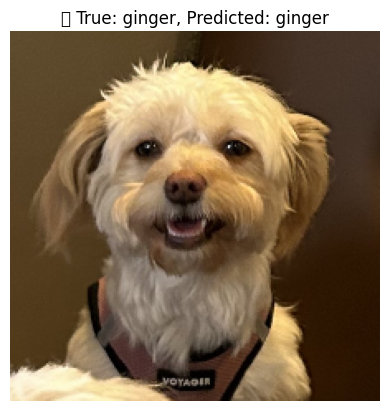

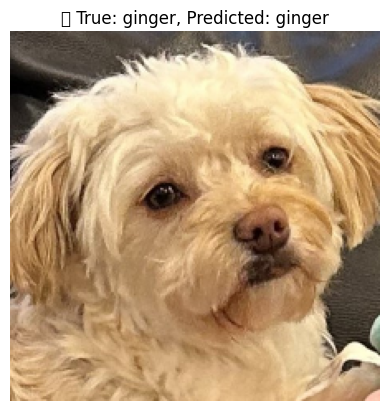

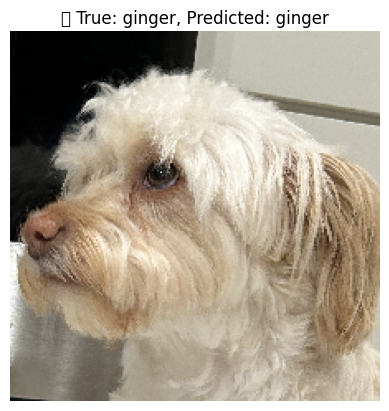

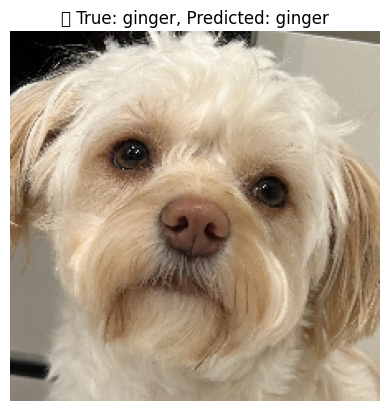

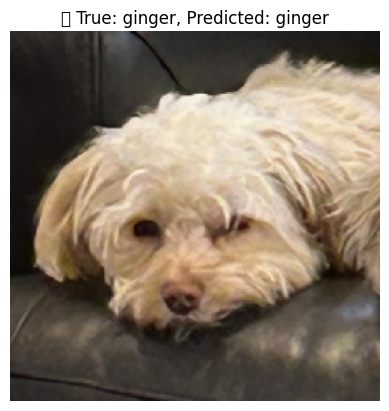

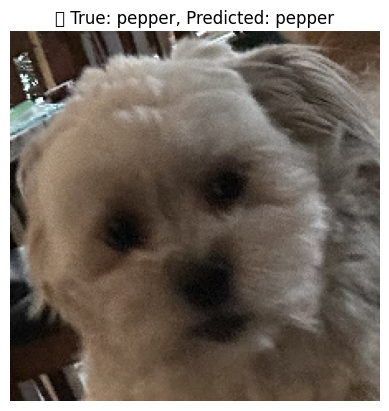

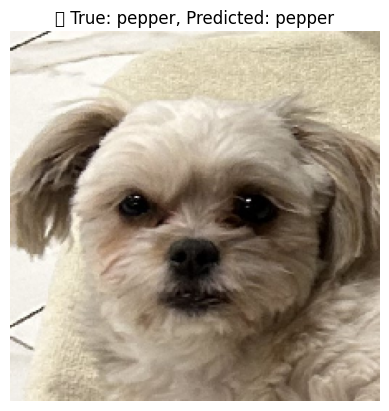

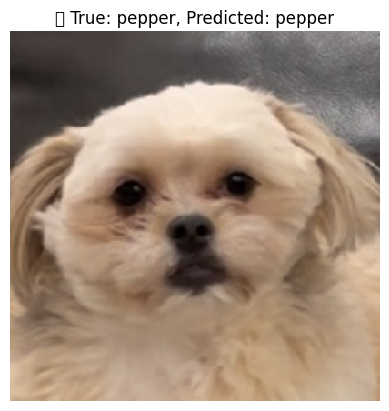

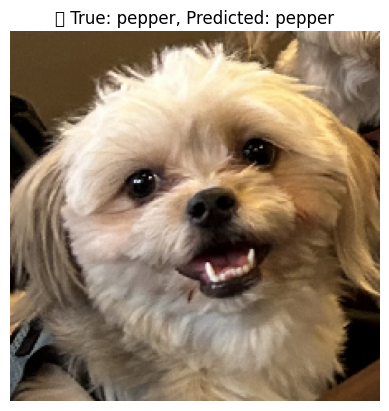

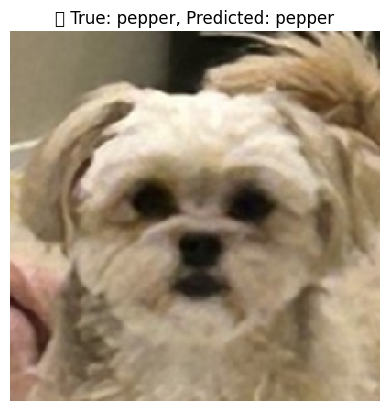

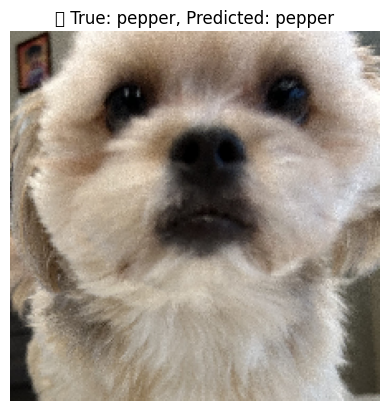

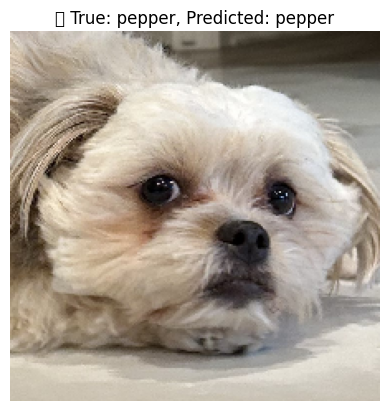

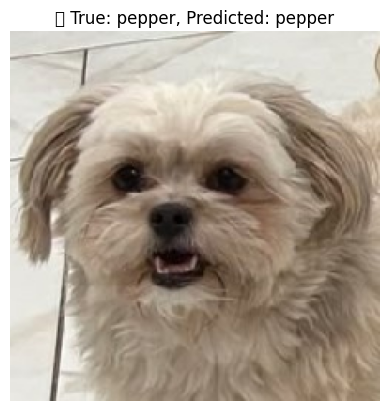

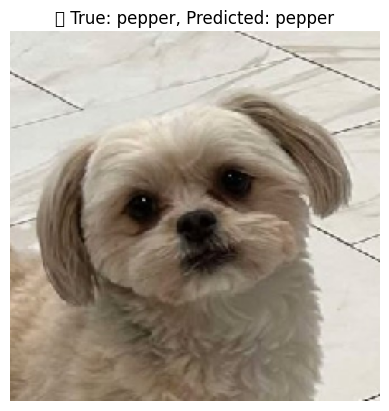

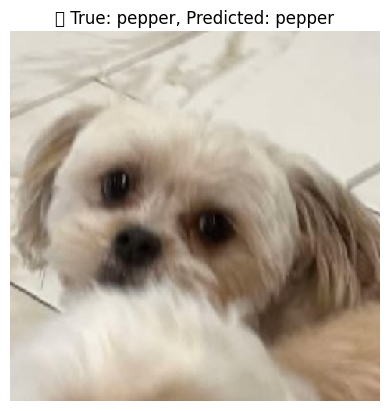

In [18]:
# --- Visualize some false predictions ---
for i in incorrect_predictions[:5]:
    img_path = test_generator.filepaths[i]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"True: {class_names[int(y_true[i])]}, Pred: {class_names[y_pred_classes[i]]}")
    plt.axis('off')
    plt.show()

# Visualize some true predictions ---
for i in correct_predictions:  # Display first 5 correct ones
    img_path = test_generator.filepaths[i]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"✅ True: {class_names[int(y_true[i])]}, Predicted: {class_names[y_pred_classes[i]]}")
    plt.axis('off')
    plt.show()

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9928 - loss: 0.0354 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9851 - loss: 0.0423 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9979 - loss: 0.0268 - val_accuracy: 1.0000 - val_loss: 3.1504e-04
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 972ms/step - accuracy: 1.0000 - loss: 0.0184 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9872 - loss: 0.0342 - val_accuracy: 1.0000 - val_loss: 6.1081e-04
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9773 - loss: 0.0434 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 971ms/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 1.0000 - val_loss: 0.0077
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9871 - loss: 0.0224 - val_accuracy: 1.0000 - val_loss: 6.4689e-0

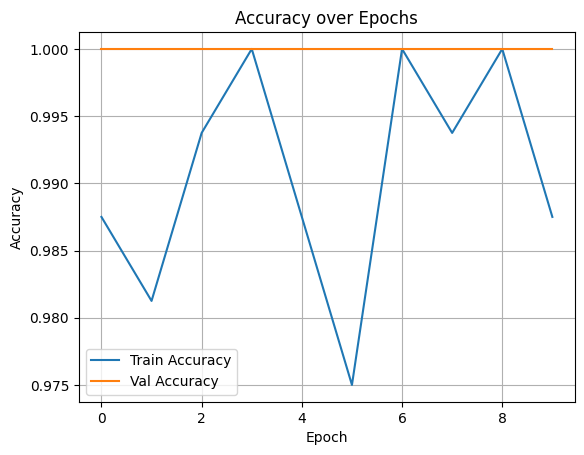

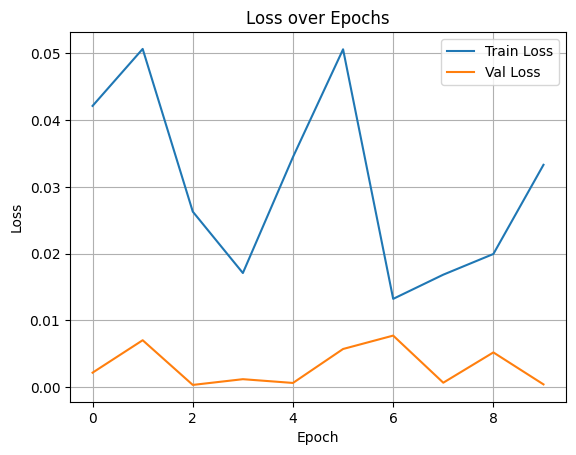

In [22]:
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [24]:
# Assuming y_true and y_pred_classes are already defined
cm = confusion_matrix(y_true, y_pred_classes)

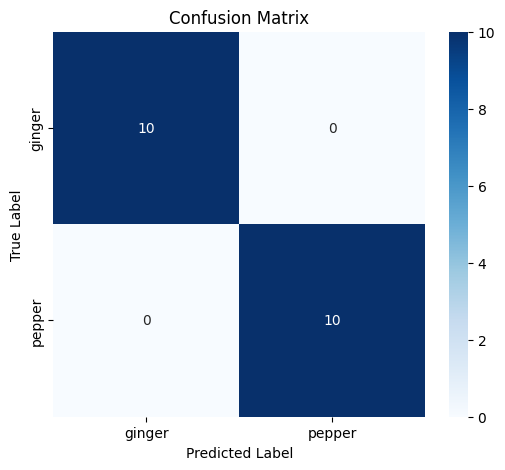

In [25]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
